# Running ParlaSpeechHR Models

## [0] Start here:

In [1]:
work_version_num = 2.1
word_version_preffix = ""
word_version_suffix = ""
work_version = f"{word_version_preffix}v{work_version_num}{word_version_suffix}"

print(work_version)

v2.1


In [196]:
choose_lm_model = False
google_colabbing = False
debug_printing = False

testing_asr = True # if False, cuts audio into chunks
shuffle_transcript = True

## [INFO ABOUT MACHINE]

In [219]:
### NEED TO REINSTALL PYTORCH WITH CUDA ENABLED AND TRY AGAIN I GUESS

In [ ]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
print("Device Name:", torch.cuda.get_device_name(0))


In [217]:
#!pip install pyopencl

import pyopencl as cl

# Get a list of all available platforms
platforms = cl.get_platforms()

for platform in platforms:
    print(f"Platform: {platform.name}")
    print(f"Vendor: {platform.vendor}")
    print(f"Version: {platform.version}")

    # Get a list of all available devices for the current platform
    devices = platform.get_devices()
    for device in devices:
        print(f"\nDevice: {device.name}")
        print(f"Type: {cl.device_type.to_string(device.type)}")
        print(f"Max Compute Units: {device.max_compute_units}")
        print(f"Max Work Item Dimensions: {device.max_work_item_dimensions}")
        print(f"Max Work Group Size: {device.max_work_group_size}")
        print(f"Max Clock Frequency: {device.max_clock_frequency} MHz")
        print(f"Global Memory Size: {device.global_mem_size / (1024 ** 3):.2f} GB")
        print(f"Local Memory Size: {device.local_mem_size / 1024:.2f} KB")
        print(f"Max Memory Allocation Size: {device.max_mem_alloc_size / (1024 ** 3):.2f} GB")
        print(f"OpenCL Version: {device.opencl_c_version}")
        print(f"Driver Version: {device.driver_version}")


Platform: NVIDIA CUDA
Vendor: NVIDIA Corporation
Version: OpenCL 1.2 CUDA 11.1.96

Device: GeForce GTX 760
Type: ALL | GPU
Max Compute Units: 6
Max Work Item Dimensions: 3
Max Work Group Size: 1024
Max Clock Frequency: 1150 MHz
Global Memory Size: 4.00 GB
Local Memory Size: 48.00 KB
Max Memory Allocation Size: 1.00 GB
OpenCL Version: OpenCL C 1.2 
Driver Version: 456.71
Platform: Intel(R) OpenCL HD Graphics
Vendor: Intel(R) Corporation
Version: OpenCL 3.0 

Device: Intel(R) UHD Graphics 750
Type: ALL | GPU
Max Compute Units: 32
Max Work Item Dimensions: 3
Max Work Group Size: 256
Max Clock Frequency: 1300 MHz
Global Memory Size: 6.32 GB
Local Memory Size: 64.00 KB
Max Memory Allocation Size: 3.16 GB
OpenCL Version: OpenCL C 1.2 
Driver Version: 30.0.101.1273
Platform: Intel(R) OpenCL
Vendor: Intel(R) Corporation
Version: OpenCL 3.0 WINDOWS

Device: 11th Gen Intel(R) Core(TM) i5-11600 @ 2.80GHz
Type: ALL | CPU
Max Compute Units: 12
Max Work Item Dimensions: 3
Max Work Group Size: 8192
M

CPU VERSION:
Device: 11th Gen Intel(R) Core(TM) i5-11600 @ 2.80GHz
Type: ALL | CPU
Max Compute Units: 12
Max Work Item Dimensions: 3
Max Work Group Size: 8192
Max Clock Frequency: 2800 MHz
Global Memory Size: 15.80 GB
Local Memory Size: 32.00 KB
Max Memory Allocation Size: 7.90 GB
OpenCL Version: OpenCL C 3.0 
Driver Version: 2023.16.6.0.28_042959

## [1] Install all required packages

In [142]:
#!pip install ipython
from IPython.display import clear_output

try:
    import transformers
    print("transformers: All good.")
except ImportError:
    !pip install transformers
    print("transformers: Installed.")

try:
    import pydub
    print("pydub: All good.")
except ImportError:
    !pip install pydub
    print("pydub: Installed.")

try:
    import torchaudio
    print("torchaudio: All good.")
except ImportError:
    !pip install torchaudio
    print("torchaudio: Installed.")

try:
    import pyctcdecode
    print("pyctcdecode: All good.")
except ImportError:
    !pip install pyctcdecode
    print("pyctcdecode: Installed.")

try:
    import jiwer
    print("jiwer: All good.")
except ImportError:
    !pip install jiwer
    print("jiwer: Installed.")

try:
    import nltk
    nltk.download('punkt')
    print("nltk: All good.")
except ImportError:
    !pip install nltk
    print("nltk: Installed.")

try:
    from fuzzywuzzy import fuzz
    print("fuzzywuzzy: All good.")
except ImportError:   
    !pip install fuzzywuzzy
    print("fuzzywuzzy: Installed.")

clear_output(wait=True) # clean the mess
print(f"All good. Every essential package is present to make the code work.")

All good. Every essential package is present to make the code work.


In [134]:
try:
    import kenlm
    print(f"All good. kenlm is present to make the LM model.")
except ImportError:
    !pip install https://github.com/kpu/kenlm/archive/master.zip # requires runtime restart
    import os
    os.kill(os.getpid(), 9) # restart automatically

All good. kenlm is present to make the LM model.


## [2] Defining all paths

In [4]:
path_to_pshr_raw_audio_data = r"D:\ParlaSpeech-HR.v1.0\raw"
path_to_pshr_raw_jsonl = r"D:\ParlaSpeech-HR.v1.0\ParlaSpeech-HR.v1.0.jsonl"

path_to_pshr_models = r"D:\ASR\ParlaspeechHR"
path_to_pshr_wav2vec2_l = r"D:\ASR\ParlaspeechHR\wav2vec2-large-slavih-hr\wav2vec2-large-slavic-parlaspeech-hr"
path_to_pshr_wav2vec2_l_lm = r"D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr-lm"

test_audio_path = r"D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr-lm\nela_film_review.ogg"

In [6]:
# # Mount gdrive and place path (private, no download)
# from google.colab import drive
# drive.mount("/content/drive")

# model_file_path = "/content/drive/MyDrive/pytorch/wav2vec2-large-slavic-hr"
# output_folder = "/content/drive/MyDrive/pytorch/wav2vec2-large-slavic-hr/temp"

# model_file_path_lm = "/content/drive/MyDrive/pytorch/wav2vec2-large-slavic-hr-lm"
# output_folder_lm = "/content/drive/MyDrive/pytorch/wav2vec2-large-slavic-hr-lm/temp"

## [3] Downloading wav2vec2 (plain or WithLM)

In [5]:
# Download HF repository manually and place path (public, ~2GB download)
import os


if google_colabbing == True:
    
    from google.colab import drive
    drive.mount("/content/drive")

    if choose_lm_model == False:
      # Check if the directory exists
      if not os.path.exists("/content/wav2vec2-large-slavic-parlaspeech-hr"):
          # Clone the repository if it doesn't exist
          !git clone https://huggingface.co/classla/wav2vec2-large-slavic-parlaspeech-hr
          os.makedirs("/content/wav2vec2-large-slavic-parlaspeech-hr/temp", exist_ok=True)
      else:
          print(f"wav2vec2-parlaspeech-hr already exists.")
    
      model_file_path = "/content/wav2vec2-large-slavic-parlaspeech-hr"
      print(f"\nUsing model from path: {model_file_path}")
    
    else:
      # Check if the directory exists
      if not os.path.exists("/content/pytorch/wav2vec2-large-slavic-hr-lm"):
          # Clone the repository if it doesn't exist
          !git clone https://huggingface.co/classla/wav2vec2-large-slavic-parlaspeech-hr-lm
          os.makedirs("/content/wav2vec2-large-slavic-parlaspeech-hr-lm/temp", exist_ok=True)
      else:
          print(f"wav2vec2-parlaspeech-hr-lm already exists.")
    
      model_file_path = "/content/pytorch/wav2vec2-large-slavic-hr-lm"
      print(f"\nUsing model from path: {model_file_path}")
        
else:
    print(f"Running localy, good luck")
    
    if choose_lm_model == False:
        model_file_path = path_to_pshr_wav2vec2_l
    else: 
        model_file_path = path_to_pshr_wav2vec2_l_lm
    print(f"\nUsing model from path: {model_file_path}")



Running localy, good luck

Using model from path: D:\ASR\ParlaspeechHR\wav2vec2-large-slavih-hr\wav2vec2-large-slavic-parlaspeech-hr


## [4] Initilize the model!

In [7]:
from transformers import Wav2Vec2Processor, Wav2Vec2ProcessorWithLM, Wav2Vec2ForCTC, Wav2Vec2FeatureExtractor, Wav2Vec2CTCTokenizer
import torch
import os
import kenlm
from pyctcdecode import BeamSearchDecoderCTC, build_ctcdecoder

# Set device as gpu, default = cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

if choose_lm_model == False:
  # Make the tokenizer
  if 'tokenizer0' not in globals():
    print(f"tokenizer0 not found. Making tokenizer0...")
    tokenizer0 = Wav2Vec2CTCTokenizer(model_file_path + "/vocab.json",
                                    unk_token="[UNK]",
                                    pad_token="[PAD]",
                                    word_delimiter_token="|")
  else:
    print(f"tokenizer0 exists.")

  # Make feature_extractor manually taken from preprocessor_config.json
  if 'feature_extractor0' not in globals():
    print(f"feature_extractor0 not found. Making feature_extractor0...")
    feature_extractor0 = Wav2Vec2FeatureExtractor(feature_size=1,
                                                sampling_rate=16000,
                                                padding_value=0.0,
                                                do_normalize=True,
                                                return_attention_mask=True)
  else:
    print(f"feature_extractor0 exists.")

  # Make the processor
  if 'processor0' not in globals():
    print(f"processor0 not found. Making processor0...")
    processor0 = Wav2Vec2Processor.from_pretrained(model_file_path)
  else:
      print("processor0 exists.")

  # Make the model
  if 'model0' not in globals():
    print(f"model0 not found. Making model0...")
    model0 = Wav2Vec2ForCTC.from_pretrained(model_file_path,
                                            config=model_file_path + "/config.json")
  else:
    print("model0 exists.")

  model0.eval()


else:
  # Make the tokenizer
  if 'tokenizer0lm' not in globals():
    print(f"tokenizer0lm not found. Making tokenizer0lm...")
    tokenizer0lm = Wav2Vec2CTCTokenizer(model_file_path + "/vocab.json",
                                    unk_token="[UNK]",
                                    pad_token="[PAD]",
                                    word_delimiter_token="|")
  else:
    print(f"tokenizer0lm exists.")

  # Make feature_extractor manually taken from preprocessor_config.json
  if 'feature_extractor0lm' not in globals():
    print(f"feature_extractor0lm not found. Making feature_extractor0lm...")
    feature_extractor0lm = Wav2Vec2FeatureExtractor(feature_size=1,
                                                    sampling_rate=16000,
                                                    padding_value=0.0,
                                                    do_normalize=True,
                                                    return_attention_mask=True)
  else:
    print(f"feature_extractor0lm exists.")

  # Make the processor
  if 'processor0lm' not in globals():
    print(f"processor0lm not found. Making processor0lm...")
    processor0lm = Wav2Vec2ProcessorWithLM.from_pretrained(model_file_path)
  else:
    print("processor0lm exists.")

  # Make the model
  if 'model0lm' not in globals():
    print(f"model0lm not found. Making model0lm...")
    model0lm = Wav2Vec2ForCTC.from_pretrained(model_file_path,
                                              config=model_file_path + "/config.json")
  else:
      print("model0lm exists.")

  model0lm.eval()


device: cpu
tokenizer0 exists.
feature_extractor0 exists.
processor0 exists.
model0 exists.


## [5] Define cutting down into temp chunks (now with DYNAMICS)

In [114]:
import torchaudio
import numpy as np
from pydub import AudioSegment

import matplotlib.pyplot as plt

TIME_CHUNK = 20
target_sr=16000

SILENCE_THRESHOLD = 0.01  # Threshold to detect silence
MIN_SILENCE_LENGTH = 0.5  # Minimum length of silence to be considered a split point in seconds


print(f"Is debug_printing on? {debug_printing}\n")

### PROCESSING ENGINE ###

def process_transcribe(input_file):
        # Begin processing:
        speech, sample_rate = torchaudio.load(input_file)

        # Process the speech with the processor
        input_values = processor0(speech, sampling_rate=sample_rate, return_tensors="pt").input_values.to(device)

        if debug_printing == True:
          print(input_values.shape)

        if input_values.dim() == 3:  # If the shape is [1, 1, audio_length]
            input_values = input_values.squeeze(0)  # Squeeze to [1, audio_length]

        if debug_printing == True:
          print(input_values.shape)

        # Perform inference
        with torch.inference_mode():
            logits = model0(input_values).logits

        if debug_printing == True:
         print("Logits shape:", logits.shape)

        # Get the predicted token IDs (greedy decoding)
        predicted_ids = torch.argmax(logits, dim=-1)

        if debug_printing == True:
          print("Predicted IDs shape:", predicted_ids.shape)

        # Convert predicted IDs to numpy array
        predicted_ids = predicted_ids.cpu().numpy()

        if debug_printing == True:
          print("Predicted IDs (numpy):", predicted_ids)

        # Decode the predicted IDs
        transcription = processor0.batch_decode(predicted_ids)[0]

        if debug_printing == True:
          print("Transcription:", transcription)

        return transcription


def transcribe(input_file, output_folder, target_sr=target_sr, TIME_CHUNK=TIME_CHUNK):
    # Load the audio
    waveform, orig_sr = torchaudio.load(input_file)

    # Check if resampling is needed
    if orig_sr != target_sr:
        resampler = torchaudio.transforms.Resample(orig_freq=orig_sr, new_freq=target_sr)
        waveform = resampler(waveform)

    # Determine the output file name and format (always WAV)
    base_name = os.path.splitext(os.path.basename(input_file))[0]

    # Convert waveform to numpy array for easier processing
    waveform_np = waveform.squeeze().numpy()


################### RUN THE WHOLE AUDIO FILES ##########################
    if testing_asr == True:
            # Directly process the entire audio without chunking
            #output_file = os.path.join(output_folder, f"{base_name}_whole.wav")
            #torchaudio.save(output_file, waveform, sample_rate=target_sr)
            tekst = process_transcribe(input_file)
            # print(f"Transcription for {base_name}: {tekst}")
            print(tekst)
            #os.remove(output_file)  # Optionally delete the temporary WAV file
    
######### ELSE CHUNKS BASED ON TIME_CHUNK INCREMENTS ##################
    else:
        # Function to detect silence points
        def find_silence_points(signal, threshold, min_silence_length, sr):
            silence_points = []
            min_silence_samples = int(min_silence_length * sr)
            is_silence = np.abs(signal) < threshold
            silence_length = 0
            for i in range(len(is_silence)):
                if is_silence[i]:
                    silence_length += 1
                    if silence_length >= min_silence_samples:
                        silence_points.append(i)
                else:
                    silence_length = 0
            return silence_points


        # Find silence points in the audio
        silence_points = find_silence_points(waveform_np, SILENCE_THRESHOLD, MIN_SILENCE_LENGTH, target_sr)
    
        if debug_printing == True:
    
            print(f"Plotting point where silence ({len(silence_points)} points) has been detected in {input_file}")
            # Plot the waveform and silence points
            plt.figure(figsize=(15, 5))
            plt.plot(waveform_np, label='Waveform')
            plt.scatter(silence_points, waveform_np[silence_points], color='red', marker='x', label='Silence Points')
            plt.xlabel('Samples')
            plt.ylabel('Amplitude')
            plt.title('Waveform with Silence Points')
            plt.legend()
            plt.show()
    
        # Split the audio at silence points
        chunk_start = 0
        for i, point in enumerate(silence_points):
            chunk_end = point
            if chunk_end - chunk_start >= TIME_CHUNK * target_sr:
                chunk = waveform[:, chunk_start:chunk_end]
                output_file = os.path.join(output_folder, f"{base_name}_temp_chunk{i}.wav")
                torchaudio.save(output_file, chunk, sample_rate=target_sr)
    
                # Process the temporary WAV file
                tekst = process_transcribe(output_file)
                time = format_time(chunk_start / target_sr)
                print(f"[{time}] {tekst}")
    
                # Optionally, you can delete the temporary WAV file after processing
                os.remove(output_file)
    
                chunk_start = chunk_end
                
        def format_time(seconds):
            minutes = int(seconds // 60)
            seconds = int(seconds % 60)
            return f"{minutes:02d}:{seconds:02d}"
    
        # Process the remaining audio if any
        if chunk_start < waveform.size(1):
            chunk = waveform[:, chunk_start:]
            output_file = os.path.join(output_folder, f"{base_name}_temp_chunk{len(silence_points)}.wav")
            torchaudio.save(output_file, chunk, sample_rate=target_sr)
            tekst = process_transcribe(output_file)
            time = format_time(chunk_start / target_sr)
            print(f"[{time}] {tekst}")
            os.remove(output_file)


print(f"Transcription function defined and active: \nSplitting audio in: {TIME_CHUNK}s segments (dynamically). \n")


Is debug_printing on? False

Transcription function defined and active: 
Splitting audio in: 20s segments (dynamically). 



## [6] Quick test to verify

In [33]:
path_to_pshr_wav2vec2_l = r"D:\ASR\ParlaspeechHR\wav2vec2-large-slavih-hr\wav2vec2-large-slavic-parlaspeech-hr"
path_to_pshr_wav2vec2_l_lm = r"D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr-lm"

#test_audio_path_pc = r"D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr-lm\nela_film_review.ogg" # WORKS WELL
test_audio_path_pc = r"D:\ASR\ParlaspeechHR\ivan_snimka.opus"

Plotting point where silence (54274 points) has been detected in D:\ASR\ParlaspeechHR\ivan_snimka.opus


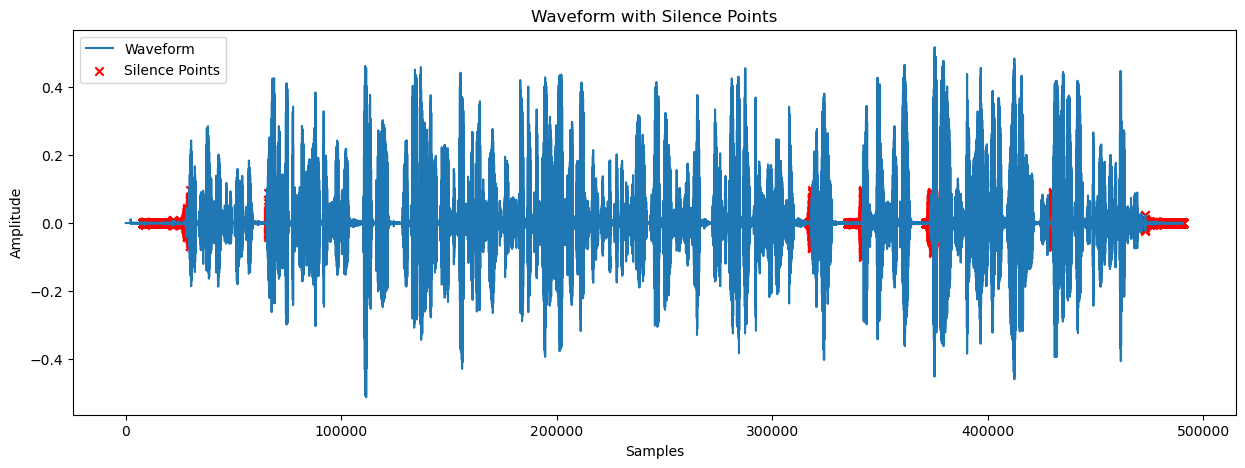

[00:00] sada ti šaljem glasovnu poruku i ne znam šta pričam ali evo pričam znači ovo tu mi je trebalo jedno 30 sati da dođem do ovog trenutka pričem normalno razgovjetno i nadam se da će transkripcija biti dobra naime ja to nisam izmislio nego su to zapravo 3 slovenca
[00:19] uzeli od facboka model i strenirali ga na govoru iz
[00:26] parlamenta specifično za hrvatski jeziku


In [34]:
if google_colabbing == True:

    test_audio_path = "/content/drive/MyDrive/pytorch/wav2vec2-large-slavic-hr-lm/ivan_snimka.opus"
    test_audio_temp = "/content/wav2vec2-large-slavic-parlaspeech-hr/temp"
    
else:
    if choose_lm_model == False:
        # Običan model
        test_audio_path = test_audio_path_pc
        test_audio_temp = path_to_pshr_wav2vec2_l + r"\temp"
        
    else:
        # LM model
        test_audio_path = test_audio_path_pc
        test_audio_temp = path_to_pshr_wav2vec2_l_lm + r"\temp"
    
transcribe(test_audio_path, test_audio_temp)

# MODEL IS NOW OPERATIONAL

## [7] Prepare to run ling analysis

In [70]:
%%time

import os

# Directory containing audio files
path_to_pshr_raw_audio_data = r"D:\ParlaSpeech-HR.v1.0\raw"

# List all files in the directory
audio_files = os.listdir(path_to_pshr_raw_audio_data)

# Count the number of audio files
num_audio_files = len(audio_files)

print(f"Number of audio files in '{path_to_pshr_raw_audio_data}': {num_audio_files}\n")

# JSONL file containing metadata
path_to_pshr_raw_jsonl = r"D:\ParlaSpeech-HR.v1.0\ParlaSpeech-HR.v1.0.jsonl"

# Counting lines in the JSONL file
num_entries = 0
with open(path_to_pshr_raw_jsonl, 'r', encoding='utf-8') as f:
    for line in f:
        num_entries += 1

print(f"Number of entries in '{path_to_pshr_raw_jsonl}': {num_entries}\n")


Number of audio files in 'D:\ParlaSpeech-HR.v1.0\raw': 403925

Number of entries in 'D:\ParlaSpeech-HR.v1.0\ParlaSpeech-HR.v1.0.jsonl': 403925

CPU times: total: 625 ms
Wall time: 635 ms


In [ ]:
import os
import json

# Paths to your data
path_to_pshr_raw_audio_data = r"D:\ParlaSpeech-HR.v1.0\raw"
path_to_pshr_raw_jsonl = r"D:\ParlaSpeech-HR.v1.0\ParlaSpeech-HR.v1.0.jsonl"

# Limit number of transcriptions to print
limit = 5
count = 0

# Read JSONL file
audio_transcriptions = {}
with open(path_to_pshr_raw_jsonl, 'r', encoding='utf-8') as jsonl_file:
    for line in jsonl_file:
        if count >= limit:
            break
        
        data = json.loads(line.strip())
        audio_filename = os.path.basename(data['path'])
        audio_transcriptions[audio_filename] = data['norm_words']  # Use 'norm_words' or other transcription field
        
        count += 1
        
audio_transcriptions = dict(sorted(audio_transcriptions.items()))

print(f"audio_transcriptions: {audio_transcriptions}")


### Generiranje audio_transcriptions dict(sorted)

In [138]:
%%time

print(f"FULL AUDIO_TRANSCRIPTIONS HERE")

import os
import json

# Paths to your data
path_to_pshr_raw_audio_data = r"D:\ParlaSpeech-HR.v1.0\raw"
path_to_pshr_raw_jsonl = r"D:\ParlaSpeech-HR.v1.0\ParlaSpeech-HR.v1.0.jsonl"

# Read JSONL file
audio_transcriptions = {}
with open(path_to_pshr_raw_jsonl, 'r', encoding='utf-8') as jsonl_file:
    for line in jsonl_file:
        data = json.loads(line.strip())
        audio_filename = os.path.basename(data['path'])
        audio_transcriptions[audio_filename] = data['norm_words']  # Use 'norm_words' or other transcription field

audio_transcriptions = dict(sorted(audio_transcriptions.items()))



FULL AUDIO_TRANSCRIPTIONS HERE
CPU times: total: 11.6 s
Wall time: 11.9 s


In [89]:
%%time

# Print limited number of audio_transcriptions
limit = 3
count = 0

print(f"Displaying first {limit} audio names w/ transcription:\n")




# List all files in the directory
all_files = os.listdir(path_to_pshr_raw_audio_data)

# Sort the files alphabetically or by any other criteria, if needed
all_files.sort()

# Select the first 10 files
first_10_files = all_files[:10]

print(f"debug_printing: {debug_printing}")

if debug_printing == True:
    # Debug prints
    print("First 10 Files:")
    print(first_10_files)
    print("\nAudio Transcriptions:")

for filename, transcription in audio_transcriptions.items():
    if count >= limit:
        break
    if debug_printing == True:
        print(f"{filename}: {transcription}")
    count += 1

# Step 3: Correlate audio files with transcriptions (limiting to 'limit' iterations)
print("\nCorrelating audio files with transcriptions:\n")
for i, audio_file in enumerate(first_10_files[:limit]):
    if audio_file in audio_transcriptions:
        transcription = ' '.join(audio_transcriptions[audio_file])
        print(f"Audio File:\n{audio_file}\n\nTranscription:\n{transcription}")
    else:
        print(f"No transcription found for {audio_file}")
    
    # Add a separator between iterations for clarity, except after the last item
    if i < (limit):
        print("-" * 30)
        print("\n")


Displaying first 3 audio names w/ transcription:

debug_printing: False

Correlating audio files with transcriptions:

Audio File:
seg.-EO06cT21uY_10038.21-10054.64.flac

Transcription:
lijepo kolegice i kolege nemojte se vi varda hihotat prije četirig ste izdali birače sad jedva čekam da vidim kako će vas nagradit jedva čekam hvala lijepo kolegice i kolega kolege zastupnici g potpredsjedniče
------------------------------


Audio File:
seg.-EO06cT21uY_10111.7-10131.55.flac

Transcription:
hadeze želi pokušati dati obećanje za šest mjeseci da će neki građani dobiti osam stotina kuna i jedina svrha ovog zakona su je kampanja odnosno izbori i predizborna kampanja jer kako drugačije objasniti da niste dali kada
------------------------------


Audio File:
seg.-EO06cT21uY_10131.55-10147.16.flac

Transcription:
ste imali rast tri posto a sada predlaže kao fol g aladrović i plenković se brinu za naše starije sugrađane i evo kad ćemo imati pad od deset posto izdvojili su osamsto kuna
--------

# TESTING TRANSCRIPTIONS now

In [119]:
# Iterate over the first 5 .flac files
for i, audio_file in enumerate(all_files[:5]):
    if audio_file.endswith('.flac'):
        flac_audio_path = os.path.join(path_to_pshr_raw_audio_data, audio_file)
        transcribe(flac_audio_path, test_audio_temp)
    else:
        print(f"Skipping non-FLAC file: {audio_file}")

    # Add a separator between iterations for clarity
    if i < 4:  # Adjust the limit based on the number of files you want to process
        print("-" * 30)

hvala lijepo kolegice i kolege nemojte se vi varda hihotat prije 4 godine ste izdali birače sada jedva čekam da vidim kako će vas nagraditi jedva čekam hvala lijepo kolegice i kolege zastupnici gospodine potpredsjedniče
------------------------------
hdz želi pokušati dati obećanje za 6 mjesci da će neki građani dobiti 8000 kuna i jedina svrha ovog zakona su je kampanja odnosno izbori i predizborna kampanja jer kako drugačije objasniti da niste dali kada
------------------------------
ste imali rast 3 a sada predlažete kao hol gospodina ladrović i plenkovića se brinu za naše starije sugrađane i evo kada ćemo imati pad ud 10 izdvojili su 800 kuna
------------------------------
ma dajte molim vas to nitko ne vjeruje to ne vjeruje nitito ne vjeruju niti djeca koja su nažalost danas doma i gledaju njih 98 školu na televiziji i bilo bi dobro da vlada rh je u stanju organizirati obrazovni sustav da
------------------------------
djeca mogu stjecati znanje i obrazovati se da pokažu da nas mog

In [207]:
## NEW

import os
from jiwer import wer
from fuzzywuzzy import fuzz

similarity_threshold = 50  # Example threshold, can be adjusted based on requirements
max_search_distance = 3  # Maximum number of tokens to search ahead for a match

# Example function to tokenize text
def tokenize_text(text):
    # You can customize tokenization based on your needs, such as handling punctuation, case sensitivity, etc.
    return text.lower().split()  # Example: split into lowercase words

# Function to normalize numbers based on the predefined mapping
def normalize_numbers(tokens, norm_nums):
    normalized_tokens = []
    for token in tokens:
        if token.lower() in norm_nums:
            normalized_tokens.append(norm_nums[token.lower()])
        elif token.isdigit() and int(token) in norm_nums:
            normalized_tokens.append(norm_nums[int(token)])
        else:
            normalized_tokens.append(token)
    return normalized_tokens

# Function to align ASR tokens with original tokens based on character similarity
def align_tokens(original_tokens, asr_tokens, similarity_threshold=similarity_threshold):
    aligned_asr_tokens = []
    asr_index = 0
    
    for original_token in original_tokens:
        found_match = False
        search_end = min(asr_index + max_search_distance, len(asr_tokens))
        for i in range(asr_index, search_end):
            asr_token = asr_tokens[i]
            similarity = fuzz.ratio(original_token, asr_token)
            
            if debug_printing == True:
                print(f"Comparing original token '{original_token}' with ASR token '{asr_token}': Similarity = {similarity}")
                
            if similarity >= similarity_threshold:
                # Found a match, so align both original and ASR tokens
                aligned_asr_tokens.append(asr_token)
                asr_index = i + 1  # Move the ASR index forward
                found_match = True
                
                if debug_printing == True:
                    print(f"Match found for '{original_token}' with '{asr_token}'")
                    
                break
        
        if not found_match:
            # No match found within the search distance, handle as needed (optional)
            # For simplicity, you can decide to skip or handle cases where no match is found
            if debug_printing == True:
                print(f"No match found for '{original_token}', handling case...")
    
    if debug_printing == True:
        print("Aligned ASR tokens:", aligned_asr_tokens)
        
    return aligned_asr_tokens

print(f"Functions online.")

Functions online.


## Definiranje znamenki (robustnost)

In [191]:
# Define the mappings for numbers in Croatian
norm_nums = {
    1: 'jedan',
    2: 'dva',
    3: 'tri',
    4: 'četiri',
    5: 'pet',
    6: 'šest',
    7: 'sedam',
    8: 'osam',
    9: 'devet',
    10: 'deset',
    11: 'jedanaest',
    12: 'dvanaest',
    13: 'trinaest',
    14: 'četrnaest',
    15: 'petnaest',
    16: 'šesnaest',
    17: 'sedamnaest',
    18: 'osamnaest',
    19: 'devetnaest',
    20: 'dvadeset',
    30: 'trideset',
    40: 'četrdeset',
    50: 'pedeset',
    60: 'šezdeset',
    70: 'sedamdeset',
    80: 'osamdeset',
    90: 'devedeset',
    100: 'sto',
    200: 'dvjesto',
    300: 'tristo',
    400: 'četiristo',
    500: 'petsto',
    600: 'šesto',
    700: 'sedamsto',
    800: 'osamsto',
    900: 'devetsto',
    1000: 'tisuća',
    2000: 'dvije tisuće',  # Two thousand
    3000: 'tri tisuće',    # Three thousand
    4000: 'četiri tisuće', # Four thousand
    5000: 'pet tisuća',    # Five thousand
    6000: 'šest tisuća',   # Six thousand
    7000: 'sedam tisuća',  # Seven thousand
    8000: 'osam tisuća',   # Eight thousand
    9000: 'devet tisuća',  # Nine thousand
}

# Create the reverse mapping for Croatian numbers
norm_nums_reverse = {value: key for key, value in norm_nums.items()}


## Run WER matching

In [208]:
%%time

# treba 4s po jednom audio fileu

import random

# Variables to accumulate metrics
num_runs = 2  # Number of runs to average over, each time picking anew randoms
max_files_to_process = 100  # Number of files to process per run
results = []

# Iterate over each run
for run in range(num_runs):
    total_asr_deletions = 0
    total_asr_additions = 0
    total_tokens = 0
    total_error_rate = 0.0
    n = 0  # Number of files processed
    
    # Shuffle the transcription list for each run if needed
    if shuffle_transcript:
        random.shuffle(transcription_list)
    
    # Process up to max_files_to_process files for this run
    for input_file, transcription in transcription_list[:max_files_to_process]:
        # Process transcription from ASR system
        tekst = process_transcribe(os.path.join(path_to_pshr_raw_audio_data, input_file))
        
        # Get original transcription from dictionary
        original_transcription = ' '.join(audio_transcriptions[input_file])
        
        # Tokenize both transcriptions
        original_tokens = tokenize_text(original_transcription)
        asr_tokens = tokenize_text(tekst)
    
        # Normalize numbers in ASR tokens
        normalized_asr_tokens = normalize_numbers(asr_tokens, norm_nums)
    
        # Align ASR tokens with original tokens based on character similarity
        aligned_asr_tokens = align_tokens(original_tokens, normalized_asr_tokens, similarity_threshold=similarity_threshold)
    
        # Calculate error metrics
        asr_deletion = len(original_tokens) - len(aligned_asr_tokens)
        asr_addition = len(normalized_asr_tokens) - len(aligned_asr_tokens)
        total_tokens += len(original_tokens)
        error_rate = (asr_deletion + asr_addition) / len(original_tokens)
    
        # Accumulate metrics
        total_asr_deletions += asr_deletion
        total_asr_additions += asr_addition
        total_error_rate += error_rate
        n += 1
    
        # Print or use the error metric for each file as needed
        if debug_printing == True:
            print(f"ASR Deletions: {asr_deletion}")
            print(f"ASR Additions: {asr_addition}")
            print(f"Total Tokens: {len(original_tokens)}")
            print(f"Error Rate (WER): {error_rate}\n")
    
    # Calculate average error metrics for this run
    average_asr_deletions = total_asr_deletions / n
    average_asr_additions = total_asr_additions / n
    average_error_rate = total_error_rate / n
    
    # Store results for this run in a dictionary
    run_result = {
        "average_asr_deletions": average_asr_deletions,
        "average_asr_additions": average_asr_additions,
        "average_error_rate": average_error_rate
    }
    
    # Append run result to results list
    results.append(run_result)

# Calculate overall averages across all runs
overall_average_asr_deletions = sum(result["average_asr_deletions"] for result in results) / num_runs
overall_average_asr_additions = sum(result["average_asr_additions"] for result in results) / num_runs
overall_average_error_rate = sum(result["average_error_rate"] for result in results) / num_runs

# Print overall average error metrics
print(f"Overall Average ASR Deletions: {overall_average_asr_deletions:.4f}")
print(f"Overall Average ASR Additions: {overall_average_asr_additions:.4f}")
print(f"Overall Average Error Rate (WER): {overall_average_error_rate:.4f}\n")

# Print number of runs
print(f"Number of runs: {len(results)}")
print(f"Total number of audio processed: {max_files_to_process*num_runs}\n")


Overall Average ASR Deletions: 2.0300
Overall Average ASR Additions: 1.6250
Overall Average Error Rate (WER): 0.1006

Number of runs: 2
Total number of audio processed: 200

CPU times: total: 1h 40min 52s
Wall time: 9min 45s


In [209]:
print(results)

[{'average_asr_deletions': 1.5, 'average_asr_additions': 1.41, 'average_error_rate': 0.08253023738503472}, {'average_asr_deletions': 2.56, 'average_asr_additions': 1.84, 'average_error_rate': 0.1186493959371065}]


# x scrap later

In [181]:
# Function to normalize numbers based on the predefined mapping
def normalize_numbers(tokens, norm_nums):
    normalized_tokens = []
    for token in tokens:
        if token.lower() in norm_nums:
            normalized_tokens.append(norm_nums[token.lower()])
        elif token.isdigit() and int(token) in norm_nums:
            normalized_tokens.append(norm_nums[int(token)])
        else:
            normalized_tokens.append(token)
    return normalized_tokens


# Assuming you have audio_transcriptions and you iterate over your ASR process
for input_file in audio_transcriptions:
    # Process transcription from ASR system
    tekst = process_transcribe(os.path.join(path_to_pshr_raw_audio_data, input_file))
    
    # Get original transcription from dictionary
    original_transcription = ' '.join(audio_transcriptions[input_file])
    
    # Tokenize both transcriptions
    original_tokens = tokenize_text(original_transcription)
    asr_tokens = tokenize_text(tekst)

    # Normalize numbers in ASR tokens
    normalized_asr_tokens = normalize_numbers(asr_tokens, norm_nums)

    # Align ASR tokens based on character similarity
    aligned_asr_tokens = align_tokens(original_tokens, normalized_asr_tokens, similarity_threshold=similarity_threshold)


    print(f"\nlen(original_tokens) {len(original_tokens)}")
    print(f"original_tokens \n{original_tokens}\n")

    # print(f"len(asr_tokens) {len(asr_tokens)}")
    # print(f"asr_tokens \n{asr_tokens}")

    print(f"\nlen(aligned_asr_tokens) {len(aligned_asr_tokens)}")
    print(f"aligned_asr_tokens \n{aligned_asr_tokens}\n")
    
    # Calculate Word Error Rate (WER) using JiWER library
    error = wer(original_tokens, aligned_asr_tokens)
    
    # Print or use the error metric as needed
    print(f"WER for {input_file}: {error}")


Comparing ASR token 'hvala' with original token 'lijepo': Similarity = 18
Comparing ASR token 'hvala' with original token 'kolegice': Similarity = 15
Comparing ASR token 'hvala' with original token 'i': Similarity = 0
No match found for 'hvala', inserting space
Comparing ASR token 'lijepo' with original token 'lijepo': Similarity = 100
Match found for 'lijepo'
Comparing ASR token 'kolegice' with original token 'kolegice': Similarity = 100
Match found for 'kolegice'
Comparing ASR token 'i' with original token 'i': Similarity = 100
Match found for 'i'
Comparing ASR token 'kolege' with original token 'kolege': Similarity = 100
Match found for 'kolege'
Comparing ASR token 'nemojte' with original token 'nemojte': Similarity = 100
Match found for 'nemojte'
Comparing ASR token 'se' with original token 'se': Similarity = 100
Match found for 'se'
Comparing ASR token 'vi' with original token 'vi': Similarity = 100
Match found for 'vi'
Comparing ASR token 'varda' with original token 'varda': Simi

ValueError: After applying the transforms on the reference and hypothesis sentences, their lengths must match. Instead got 34 reference and 35 hypothesis sentences.

In [180]:
import os
from jiwer import wer
from fuzzywuzzy import fuzz

similarity_threshold = 50  # Example threshold, can be adjusted based on requirements

# Example function to tokenize text
def tokenize_text(text):
    # You can customize tokenization based on your needs, such as handling punctuation, case sensitivity, etc.
    return text.lower().split()  # Example: split into lowercase words

# Function to align ASR tokens with original tokens based on character similarity
def align_tokens(original_tokens, asr_tokens, similarity_threshold=similarity_threshold):
    
    max_search_distance = 3  # Maximum number of tokens to search ahead for a match
    
    aligned_asr_tokens = []
    original_index = 0
    
    for asr_token in asr_tokens:
        found_match = False
        search_end = min(original_index + max_search_distance, len(original_tokens))
        for i in range(original_index, search_end):
            original_token = original_tokens[i]
            similarity = fuzz.ratio(asr_token, original_token)
            print(f"Comparing ASR token '{asr_token}' with original token '{original_token}': Similarity = {similarity}")
            if similarity >= similarity_threshold:
                # Found a match, so align the ASR token with the original token
                aligned_asr_tokens.append(asr_token)
                original_index = i + 1  # Move the original index forward
                found_match = True
                print(f"Match found for '{asr_token}'")
                break
        
        if not found_match:
            # No match found within the search distance, insert a space
            aligned_asr_tokens.append(' ')
            print(f"No match found for '{asr_token}', inserting space")
            
    ####### TRYING TO NEGATE WHEN IT COMBINES TWO WORDS INTO ONE        

    # Clean up: remove consecutive empty tokens except for the first one if it's alone
    final_aligned_asr_tokens = []
    for i, token in enumerate(aligned_asr_tokens):
        if token == ' ' and i < len(aligned_asr_tokens) - 1 and aligned_asr_tokens[i + 1] == ' ':
            continue  # Skip consecutive empty tokens
        final_aligned_asr_tokens.append(token)

    aligned_asr_tokens = final_aligned_asr_tokens
    # print("Aligned ASR tokens:", aligned_asr_tokens)

    return aligned_asr_tokens

# Assuming you have audio_transcriptions and you iterate over your ASR process
for input_file in audio_transcriptions:
    # Process transcription from ASR system
    tekst = process_transcribe(os.path.join(path_to_pshr_raw_audio_data, input_file))
    
    # Get original transcription from dictionary
    original_transcription = ' '.join(audio_transcriptions[input_file])
    
    # Tokenize both transcriptions
    original_tokens = tokenize_text(original_transcription)
    asr_tokens = tokenize_text(tekst)

    # Align ASR tokens based on character similarity
    aligned_asr_tokens = align_tokens(original_tokens, asr_tokens, similarity_threshold=similarity_threshold)


    print(f"\nlen(original_tokens) {len(original_tokens)}")
    print(f"original_tokens \n{original_tokens}\n")

    # print(f"len(asr_tokens) {len(asr_tokens)}")
    # print(f"asr_tokens \n{asr_tokens}")

    print(f"\nlen(aligned_asr_tokens) {len(aligned_asr_tokens)}")
    print(f"aligned_asr_tokens \n{aligned_asr_tokens}\n")

    
    # Calculate Word Error Rate (WER) using JiWER library
    error = wer(original_tokens, aligned_asr_tokens)
    
    # Print or use the error metric as needed
    print(f"WER for {input_file}: {error}")


Comparing ASR token 'hvala' with original token 'lijepo': Similarity = 18
Comparing ASR token 'hvala' with original token 'kolegice': Similarity = 15
Comparing ASR token 'hvala' with original token 'i': Similarity = 0
No match found for 'hvala', inserting space
Comparing ASR token 'lijepo' with original token 'lijepo': Similarity = 100
Match found for 'lijepo'
Comparing ASR token 'kolegice' with original token 'kolegice': Similarity = 100
Match found for 'kolegice'
Comparing ASR token 'i' with original token 'i': Similarity = 100
Match found for 'i'
Comparing ASR token 'kolege' with original token 'kolege': Similarity = 100
Match found for 'kolege'
Comparing ASR token 'nemojte' with original token 'nemojte': Similarity = 100
Match found for 'nemojte'
Comparing ASR token 'se' with original token 'se': Similarity = 100
Match found for 'se'
Comparing ASR token 'vi' with original token 'vi': Similarity = 100
Match found for 'vi'
Comparing ASR token 'varda' with original token 'varda': Simi

ValueError: After applying the transforms on the reference and hypothesis sentences, their lengths must match. Instead got 37 reference and 36 hypothesis sentences.

In [46]:
import os

# Path to the directory containing audio files
path_to_pshr_raw_audio_data = r"D:\ParlaSpeech-HR.v1.0\raw"

# List all files in the directory
all_files = os.listdir(path_to_pshr_raw_audio_data)

# Sort the files alphabetically or by any other criteria, if needed
all_files.sort()

# Select the first 10 files
first_10_files = all_files[:10]

# Print the first 10 files
for file in first_10_files:
    print(file)


seg.-EO06cT21uY_10038.21-10054.64.flac
seg.-EO06cT21uY_10111.7-10131.55.flac
seg.-EO06cT21uY_10131.55-10147.16.flac
seg.-EO06cT21uY_10148.69-10167.91.flac
seg.-EO06cT21uY_10167.91-10186.62.flac
seg.-EO06cT21uY_10187.44-10207.4.flac
seg.-EO06cT21uY_10207.4-10227.1.flac
seg.-EO06cT21uY_10227.1-10246.72.flac
seg.-EO06cT21uY_10246.72-10265.92.flac
seg.-EO06cT21uY_10266.15-10285.99.flac
